<a href="https://colab.research.google.com/github/raphael-fawaz/Financial-Markets-Analysis-and-Prediction/blob/Bi-LSTM-(Dow-Jones-%26-Nasdaq)---Close-Price/LSTM_(Dwo_Jones)_Multiple_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM  (Dwo Jones) - Multiple features

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Load the Dow Jones data
dow_data = pd.read_csv("dow_data.csv", index_col="Date", parse_dates=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
dow_scaled = scaler.fit_transform(dow_data)

In [ ]:
dow_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,10430.690430,10604.969727,10430.690430,10583.959961,10583.959961,179780000
2010-01-05,10584.559570,10584.559570,10522.519531,10572.019531,10572.019531,188540000
2010-01-06,10564.719727,10594.990234,10546.549805,10573.679688,10573.679688,186040000
2010-01-07,10571.110352,10612.370117,10505.209961,10606.860352,10606.860352,217390000
2010-01-08,10606.400391,10619.400391,10554.330078,10618.190430,10618.190430,172710000


## Preparing data

In [ ]:
# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length, 3])  # The 'Close' price is at index 3
    return np.array(sequences), np.array(labels)

In [ ]:
seq_length = 60  # Use 60 days of data to predict the next day's price
dow_sequences, dow_labels = create_sequences(dow_scaled, seq_length)
# Determine the index to split the data for the test set (last 60 days)
test_size = 60
train_sequences = dow_sequences[:-test_size]
test_sequences = dow_sequences[-test_size:]
train_labels = dow_labels[:-test_size]
test_labels = dow_labels[-test_size:]

## LSTM (Single layer model)

In [ ]:
# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(seq_length, dow_data.shape[1])),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
history = model.fit(train_sequences, train_labels, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
86/86 [==============================] - 2s 29ms/step - loss: 6.9026e-04 - val_loss: 5.0966e-04
Epoch 2/20
86/86 [==============================] - 2s 28ms/step - loss: 6.7032e-04 - val_loss: 3.1292e-04
Epoch 3/20
86/86 [==============================] - 2s 28ms/step - loss: 6.8534e-04 - val_loss: 3.4910e-04
Epoch 4/20
86/86 [==============================] - 2s 28ms/step - loss: 6.1677e-04 - val_loss: 3.7122e-04
Epoch 5/20
86/86 [==============================] - 2s 28ms/step - loss: 5.4552e-04 - val_loss: 2.6630e-04
Epoch 6/20
86/86 [==============================] - 2s 28ms/step - loss: 5.6970e-04 - val_loss: 0.0014
Epoch 7/20
86/86 [==============================] - 2s 28ms/step - loss: 5.9937e-04 - val_loss: 9.5446e-04
Epoch 8/20
86/86 [==============================] - 2s 28ms/step - loss: 5.7038e-04 - val_loss: 4.2092e-04
Epoch 9/20
86/86 [==============================] - 2s 29ms/step - loss: 5.1485e-04 - val_loss: 2.6268e-04
Epoch 10/20
86/86 [======================

## Prediction

2/2 [==============================] - 1s 0s/step
Root Mean Squared Error: 0.013510355197263884


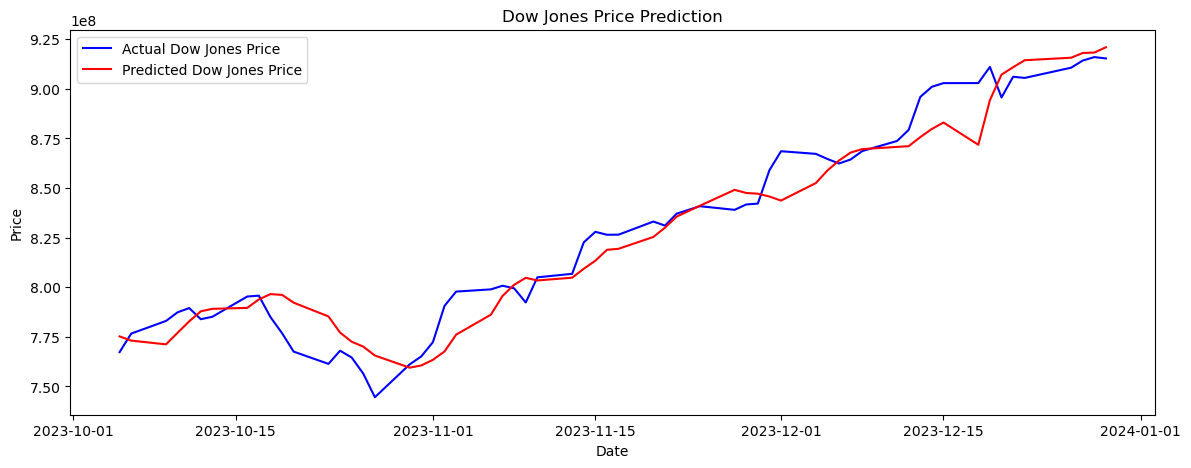

In [ ]:
# Predict on the test data
predictions = model.predict(test_sequences)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_labels, predictions))
print(f'Root Mean Squared Error: {rmse}')


# Inverse transform the predictions and test labels
predictions = scaler.inverse_transform(np.concatenate((np.zeros((predictions.shape[0], dow_data.shape[1]-1)), predictions), axis=1))[:, -1]
test_labels = scaler.inverse_transform(np.concatenate((np.zeros((test_labels.shape[0], dow_data.shape[1]-1)), test_labels.reshape(-1, 1)), axis=1))[:, -1]

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(dow_data.index[-len(test_labels):], test_labels, color='blue', label='Actual Dow Jones Price')
plt.plot(dow_data.index[-len(test_labels):], predictions, color='red', label='Predicted Dow Jones Price')
plt.title('Dow Jones Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
